In [20]:
import pandas as pd
import duckdb
import os
import os, json
from uuid import uuid4
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#pd.set_option("display.width", 500)  # adjusts total line width before wrapping
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer
import faiss
from sklearn.preprocessing import normalize
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import matplotlib.pyplot as plt
import re
import unicodedata
from sklearn.preprocessing import normalize


In [7]:
try:
    file_data = json.load(open(os.path.expanduser("~/ServiceAccountsKey.json")))
    # (2) transform the content into crendentials object
    credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
    scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
    gc = gspread.Client(auth=scoped_credentials)
    grela_gs = gc.open_by_url("https://docs.google.com/spreadsheets/d/1QroTEQ9gQf9cLO9mvolp7fELNbYYjgvGd48yAiTj03w/edit?usp=sharing")
except:
    pass

In [9]:
model = SentenceTransformer("sentence-transformers/LaBSE")

In [10]:
conn = duckdb.connect('/srv/data/grela_v0-2.duckdb', read_only=True)

In [6]:
query = """
        SELECT w.*
        FROM works w
        """
works_df = conn.execute(query).fetchdf()

In [8]:
works_df.head(5)

,grela_source,grela_id,author,title,not_before,not_after,lagt_tlg_epithet,lagt_genre,lagt_provenience,noscemus_place,noscemus_genre,noscemus_discipline,title_short,emlap_noscemus_id,place_publication,place_geonames,author_viaf,title_viaf,date_random,token_count
0,lagt,lagt_ggm0001.ggm001,Anonymous,Anametresis Pontou,1.0,400.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,372.0,0
1,lagt,lagt_ogl0001.ogl001,Pinytus,De Epistola Pinyti ad Dionysium,101.0,200.0,[],[],christian,None,None,None,None,NaN,None,None,NaN,NaN,135.0,109
2,lagt,lagt_pta0001.pta001,Severian of Gabala,De fide et lege naturae,400.0,409.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,403.0,0
3,lagt,lagt_pta0001.pta002,Severian of Gabala,De paenitentia et compunctione,400.0,409.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,409.0,0
4,lagt,lagt_pta0001.pta003,Severian of Gabala,In ascensionem domini nostri Iesu Christi et in principium Actorum,400.0,409.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,402.0,0


In [9]:
def add_cc_link(grela_id):
    if "cc_" in grela_id:
        url = "https://mlat.uzh.ch/" + grela_id.rpartition("_")[2]
        return url
works_df["cc_link"] = works_df["grela_id"].apply(add_cc_link)

In [10]:
works_df[5000:5010]

,grela_source,grela_id,author,title,not_before,not_after,lagt_tlg_epithet,lagt_genre,lagt_provenience,noscemus_place,...,noscemus_discipline,title_short,emlap_noscemus_id,place_publication,place_geonames,author_viaf,title_viaf,date_random,token_count,cc_link
5000,cc,cc_14322,Servius,Commentarius in Vergilii Aeneidos libros,400.0,400.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,400.0,280935,https://mlat.uzh.ch/14322
5001,cc,cc_14325,Grillius,Commentum in Ciceronis rhetorica,450.0,450.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,450.0,26692,https://mlat.uzh.ch/14325
5002,cc,cc_14326,Iulius Honorius,Cosmographia,350.0,350.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,350.0,5307,https://mlat.uzh.ch/14326
5003,cc,cc_14327,Gargilius Martialis,Curae boum ex corpore Gargili Martialis,260.0,260.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,260.0,1058,https://mlat.uzh.ch/14327
5004,cc,cc_14331,Fabius Planciades Fulgentius,De aetatibus mundi et hominis,500.0,500.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,500.0,11272,https://mlat.uzh.ch/14331
5005,cc,cc_14335,Evanthius,De comoedia uel de fabula,358.0,358.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,358.0,1701,https://mlat.uzh.ch/14335
5006,cc,cc_14336,Siculus Flaccus,De condicionibus agrorum,300.0,300.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,300.0,7160,https://mlat.uzh.ch/14336
5007,cc,cc_14337,Agennius Urbicus,De controuersiis agrorum,400.0,400.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,400.0,7675,https://mlat.uzh.ch/14337
5008,cc,cc_14338,Censorinus,De die natali liber ad Q. Caerellium,238.0,238.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,238.0,12482,https://mlat.uzh.ch/14338
5009,cc,cc_14339,Boetius,De differentiis topicis,480.0,525.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,501.0,21217,https://mlat.uzh.ch/14339


In [19]:
works_df.columns

Index(['grela_source', 'grela_id', 'author', 'title', 'not_before', 'not_after', 'lagt_tlg_epithet', 'lagt_genre', 'lagt_provenience', 'noscemus_place', 'noscemus_genre', 'noscemus_discipline', 'title_short', 'emlap_noscemus_id', 'place_publication', 'place_geonames', 'author_viaf', 'title_viaf', 'date_random', 'token_count', 'cc_link'], dtype='object')

In [20]:
set_with_dataframe(grela_gs.add_worksheet("grela_works_v0-2_short", 1,1), works_df[['grela_source', 'grela_id', 'cc_link', 'author', 'title', 'not_before', 'not_after',  'token_count', 'cc_link']].sort_values("not_before", ascending=True))

In [7]:
vulgate_df = conn.execute("""
    SELECT e.sentence_id, e.embedding, w.title
    FROM sentence_embeddings e
    JOIN sentences s ON e.sentence_id = s.sentence_id
    JOIN works w ON s.grela_id = w.grela_id
    WHERE e.grela_id LIKE 'vulgate_%'
""").fetchdf()

# Convert JSON to numpy array
embeddings = np.array([json.loads(e) for e in vulgate_df['embedding']]).astype('float32')
sentence_ids = vulgate_df['sentence_id'].tolist()

In [8]:
titles = vulgate_df['title'].tolist()

In [9]:
normalized_embeddings = normalize(embeddings, norm='l2')

In [10]:
d = normalized_embeddings.shape[1]  # 768
index = faiss.IndexFlatIP(d)        # Inner product = cosine if normalized
index.add(normalized_embeddings)

In [11]:
query = "The Word became flesh and made his dwelling among us. We have seen his glory, the glory of the one and only Son, who came from the Father, full of grace and truth."
embedding = model.encode([query], convert_to_numpy=True)
# Normalize for cosine similarity
embedding = normalize(embedding, norm='l2')

In [12]:
k = 5  # number of nearest neighbors
scores, indices = index.search(embedding, k)

In [13]:
results = []
for idx, score in zip(indices[0], scores[0]):
    sid = sentence_ids[idx]
    row = conn.execute(f"""
        SELECT s.sentence_id, s.text, w.title
        FROM sentences s
        JOIN works w ON s.grela_id = w.grela_id
        WHERE s.sentence_id = '{sid}'
    """).fetchone()

    if row:
        sentence_id, text, title = row
        results.append({
            "score": score,
            "sentence_id": sentence_id,
            "text": text,
            "title": title
        })

# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="score", ascending=False).reset_index(drop=True)
df_results

,score,sentence_id,text,title
0,0.787623,vulgate_tlg0031.tlg004.obi-lat:1.14,et Verbum caro factum est et habitavit in nobis et vidimus gloriam eius gloriam quasi unigeniti a Patre plenum gratiae et veritatis,Vulgate - John
1,0.588898,vulgate_tlg0527.tlg048.obi-lat:9.6,parvulus enim natus est nobis filius datus est nobis et factus est principatus super umerum eius et vocabitur nomen eius Admirabilis consiliarius Deus fortis Pater futuri saeculi Princeps pacis,Vulgate - Isaiah
2,0.552220,vulgate_tlg0031.tlg023.obi-lat:5.20,et scimus quoniam Filius Dei venit et dedit nobis sensum ut cognoscamus verum Deum et simus in vero Filio eius hic est verus Deus et vita aeterna,Vulgate - 1 John
3,0.508574,vulgate_tlg0527.tlg005.obi-lat:5.24,ecce ostendit nobis Dominus Deus noster maiestatem et magnitudinem suam vocem eius audivimus de medio ignis et probavimus hodie quod loquente Deo cum homine vixerit homo,Vulgate - Deuteronomy
4,0.505002,vulgate_tlg0527.tlg046.obi-lat:9.7,et auferam sanguinem eius de ore eius et abominationes eius de medio dentium eius et relinquetur etiam ipse Deo nostro et erit quasi dux in Iuda et Accaron quasi Iebuseus,Vulgate - Zechariah


In [11]:
# load the register
register_df = conn.execute("""
    SELECT s.sentence_id, s.text, s.subwork_id, e.embedding
    FROM sentence_embeddings e
    JOIN sentences s ON e.sentence_id = s.sentence_id
    WHERE e.grela_id = 'cc_10265'
""").fetchdf()

In [12]:
register_df[13:25]

,sentence_id,text,subwork_id,embedding
13,cc_10265_13,Te itaque per omnipotentem Dominum rogo ut suffraganeos fratres et filios quos in Christo nutris ad exorandum Deum pro me provoces et ex vera charitate invites quatenus oratio quae me liberare deb...,1,"[-0.017833760008215904, -0.036328550428152084, -0.049867212772369385, -0.002716419752687216, -0.06183719262480736, -0.014686702750623226, -0.06731430441141129, -0.013452722690999508, -0.0246018748..."
14,cc_10265_14,Tu autem ipse quantocius ad nos venire non praetermittas qui quantum Romana Ecclesia te indigeat et in prudentia tua fiduciam habeat non ignoras,1,"[0.012611412443220615, 0.033647019416093826, 0.010810423642396927, -0.04135672003030777, 0.012691216543316841, -0.033400729298591614, -0.09222649037837982, 0.012711850926280022, 0.0513538457453250..."
15,cc_10265_15,Dominam Agnetem imperatricem et Rainaldum venerabilem Cumanum episcopum ex nostra parte saluta et quantum erga nos dilectionis habuerint nunc Data Datum et sic semper Romae XI IX ostendant nostra ...,1,"[0.02625245414674282, 0.05913974344730377, -0.01806396245956421, 0.009729071520268917, -0.01852743700146675, -0.006239869631826878, -0.06592336297035217, -0.04656045511364937, 0.05067339912056923,..."
16,cc_10265_16,Data Datum et sic semper Romae XI IX,1,"[-0.07001303881406784, -0.03501569479703903, -0.05015438050031662, -0.011924861930310726, -0.04248003661632538, 0.012918881140649319, -0.01362245436757803, -0.03852573782205582, 0.0205649826675653..."
17,cc_10265_17,Kalendas Maii indictione XI,1,"[-0.03895942121744156, 0.008816152811050415, 0.012267065234482288, -0.027552813291549683, -0.021558469161391258, 0.002533916151151061, -0.059541087597608566, -0.008935551159083843, 0.0409485474228..."
18,cc_10265_18,Epistola II,2,"[0.008189138025045395, -0.025606106966733932, 0.012929972261190414, 0.006861355621367693, -0.02095045894384384, 0.03459508344531059, -0.07834944128990173, 0.003305696416646242, -0.0361846014857292..."
19,cc_10265_19,AD Gisulfum Principem Salernitanum,2,"[-0.02851235680282116, 0.03368629142642021, 0.07837669551372528, 0.014486283995211124, -0.012545261532068253, -0.0024012946523725986, -0.04461389034986496, -0.031792692840099335, -0.03331127390265..."
20,cc_10265_20,Anno 1073,2,"[-0.02219068631529808, -0.03296070545911789, -0.053982239216566086, -0.044903550297021866, -0.05016487091779709, 0.04172848165035248, 0.02220061607658863, 0.01945260539650917, -0.06207734346389770..."
21,cc_10265_21,Ejusdem argumenti,2,"[0.06312298029661179, -0.006533219013363123, -0.008806036785244942, 0.0031502891797572374, 0.04595676437020302, 0.0008612061501480639, -0.0779963806271553, 0.033844709396362305, -0.089389935135841..."
22,cc_10265_22,Gregorius in Romanum pontificem electus Gisulfo Salernitano principi salutem in Christo Jesu,2,"[0.007128929253667593, -0.04280272126197815, 0.0005717139574699104, -0.03481133654713631, -0.0021913759410381317, -0.04237842187285423, -0.04069354385137558, -0.03967558965086937, -0.0180806256830..."


In [27]:
import numpy as np
import json

def detect_vulgate_verse(embedding_json, min_sim=0.6):
    if isinstance(embedding_json, str):
        embedding = np.array(json.loads(embedding_json)).reshape(1, -1).astype('float32')
    else:
        embedding = np.array(embedding_json).reshape(1, -1).astype('float32')

    embedding = embedding / np.linalg.norm(embedding, axis=1, keepdims=True)
    scores, indices = index.search(embedding, 1)
    score = scores[0][0]
    idx = indices[0][0]

    if score >= min_sim:
        sid = sentence_ids[idx]
        title = titles[idx]
        row = conn.execute(f"""
            SELECT text FROM sentences WHERE sentence_id = '{sid}'
        """).fetchone()
        if row:
            return score, sid, row[0], title  # score, sentence_id, text, title

    return None, None, None, None

In [28]:
def safe_detect(row):
    if len(row["text"].split()) > 5:
        return detect_vulgate_verse(row["embedding"])
    else:
        return (None, None, None, None)

register_df[["score", "vulgate_sentence_id", "vulgate_text", "vulgate_title"]] = (
    register_df.apply(safe_detect, axis=1, result_type="expand")
)

In [29]:
len(register_df)

5399

In [30]:
register_df["vulgate_sentence_id"].notnull().sum()

1141

In [31]:
register_df[register_df["vulgate_sentence_id"].notnull()].sort_values("score", ascending=False).head(10)

,sentence_id,text,subwork_id,embedding,score,vulgate_sentence_id,vulgate_text,vulgate_title
366,cc_10265_366,Quare faciem tuam avertis oblivisceris inopiae nostrae et tribulationis nostrae,23,"[-0.009683744050562382, -0.025561725720763206, 0.04008451849222183, -0.04783414676785469, 0.002023817040026188, 0.006924851797521114, -0.016584252938628197, 0.05008704960346222, -0.061439514160156...",0.968129,vulgate_tlg0527.tlg027.obi-lat:43.24,quare faciem tuam avertis oblivisceris inopiae nostrae et tribulationis nostrae,Vulgate - Psalms
2113,cc_10265_2113,Posui te hodie super gentes et regna ut evellas et destruas et disperdas et dissipes et aedifices et plantes,155,"[-0.05323953926563263, 0.030314967036247253, -0.03705286234617233, -0.030638594180345535, 0.04316404089331627, 0.0028370553627610207, 0.011180889792740345, -0.05149247869849205, -0.046665269881486...",0.966330,vulgate_tlg0527.tlg049.obi-lat:1.10,ecce constitui te hodie super gentes et super regna ut evellas et destruas et disperdas et dissipes et aedifices et plantes,Vulgate - Jeremiah
38,cc_10265_38,Denique timor et tremor venerunt super me et contexerunt me tenebrae,3,"[-0.030305584892630577, -0.008691239170730114, -0.01162863802164793, -0.06413891911506653, 0.017597641795873642, 0.054732345044612885, 0.01012697909027338, 0.037216294556856155, -0.008575101383030...",0.926833,vulgate_tlg0527.tlg027.obi-lat:54.6,timor et tremor venit super me et contexit me tenebra,Vulgate - Psalms
3312,cc_10265_3312,Et illud Tanquam prodigium factus sum multis et tu adjutor fortis,234,"[0.002201254479587078, -0.014360223896801472, -0.024123672395944595, -0.02689768560230732, -0.08352100849151611, 0.018729018047451973, 0.01852981187403202, 0.010897663421928883, -0.016095818951725...",0.907632,vulgate_tlg0527.tlg027.obi-lat:70.7,tamquam prodigium factus sum multis et tu adiutor fortis,Vulgate - Psalms
363,cc_10265_363,Non enim sunt condignae passiones hujus temporis ad superventuram gloriam quae revelabitur in nobis,23,"[0.020778443664312363, 0.008019705303013325, -0.05013994872570038, -0.03929687291383743, 0.03382183238863945, 0.016125820577144623, -0.055793050676584244, -0.003018895396962762, -0.050033226609230...",0.902710,vulgate_tlg0031.tlg006.obi-lat:8.18,existimo enim quod non sunt condignae passiones huius temporis ad futuram gloriam quae revelabitur in nobis,Vulgate - Romans
2566,cc_10265_2566,Majorem charitatem nemo habet ut animam suam ponat quis pro amicis suis,184,"[0.03568434715270996, -0.05725627392530441, -0.06554549187421799, 0.0217913668602705, -0.011411917395889759, -0.03018910624086857, -0.04647248983383179, -0.054484885185956955, -0.03145220875740051...",0.899220,vulgate_tlg0031.tlg004.obi-lat:15.13,maiorem hac dilectionem nemo habet ut animam suam quis ponat pro amicis suis,Vulgate - John
4278,cc_10265_4278,Et illud Qui maledixerit patri vel matri morte moriatur,303,"[-0.01277065183967352, -0.043218474835157394, 0.0030733926687389612, 0.005610625259578228, 0.03474852070212364, -0.05083023011684418, -0.004215276800096035, -0.04851352050900459, -0.01424132287502...",0.862608,vulgate_tlg0527.tlg002.obi-lat:21.17,qui maledixerit patri suo et matri morte moriatur,Vulgate - Exodus
3025,cc_10265_3025,Non enim habemus hic manentem civitatem sed futuram inquirimus cujus artifex et conditor Deus,213,"[-0.0005209576920606196, -0.00603557238355279, -0.0695071667432785, -0.06510841846466064, -0.02494661696255207, 0.018140966072678566, -0.03013847954571247, 0.0024925945326685905, -0.01429507136344...",0.818398,vulgate_tlg0031.tlg019.obi-lat:13.14,non enim habemus hic manentem civitatem sed futuram inquirimus,Vulgate - Hebrews
4277,cc_10265_4277,Sint tibi indissolubiliter infixa praecepta et monita divina Honora patrem et matrem ut sis longaevus super terram,303,"[-0.0059640416875481606, -0.04491414129734039, -0.01202736608684063, -0.05262839049100876, 0.005447876639664173, -0.007975286804139614, -0.021892910823225975, -0.022341936826705933, -0.05681291595...",0.805749,vulgate_tlg

In [32]:
register_matches = register_df[register_df["vulgate_sentence_id"].notnull()].copy()

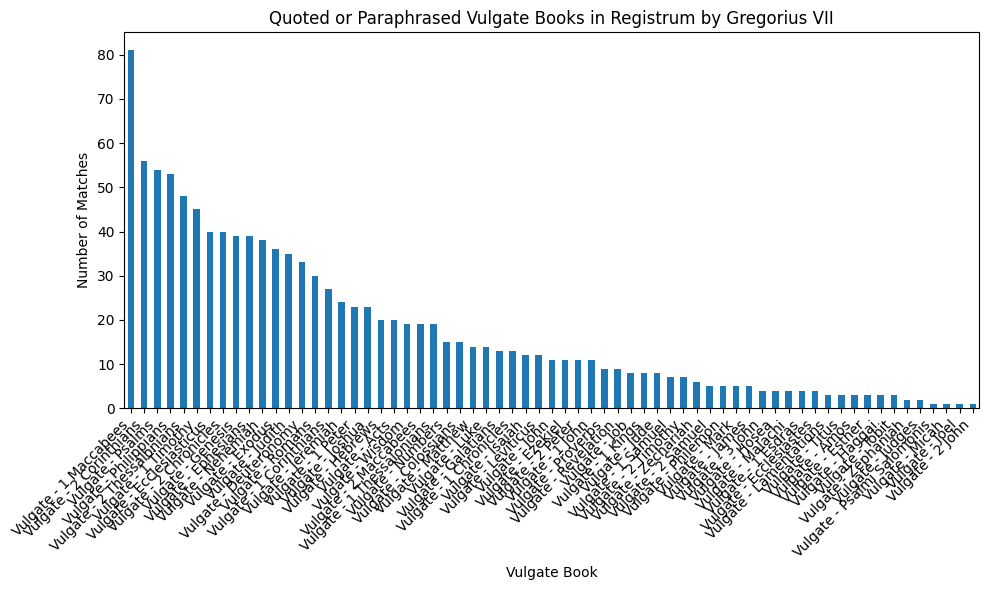

In [33]:
# Filter only matched rows (non-null vulgate_title)
matched = register_df[register_df["vulgate_title"].notnull()]

# Count occurrences
title_counts = matched["vulgate_title"].value_counts()

# Plot
plt.figure(figsize=(10, 6))
title_counts.plot(kind="bar")
plt.xlabel("Vulgate Book")
plt.ylabel("Number of Matches")
plt.title("Quoted or Paraphrased Vulgate Books in Registrum by Gregorius VII")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [34]:
register_matches["citation"] = register_matches.apply(lambda row: row["vulgate_title"].rpartition(" - ")[2] + " " + row["vulgate_sentence_id"].rpartition("lat:")[2], axis=1)

In [35]:
register_matches.sort_values("score", ascending=False, inplace=True)

In [36]:
register_matches = register_matches[['sentence_id', 'subwork_id', 'text', 'vulgate_text', 'score', 'citation', 'vulgate_sentence_id']]
register_matches.head(10)

,sentence_id,subwork_id,text,vulgate_text,score,citation,vulgate_sentence_id
366,cc_10265_366,23,Quare faciem tuam avertis oblivisceris inopiae nostrae et tribulationis nostrae,quare faciem tuam avertis oblivisceris inopiae nostrae et tribulationis nostrae,0.968129,Psalms 43.24,vulgate_tlg0527.tlg027.obi-lat:43.24
2113,cc_10265_2113,155,Posui te hodie super gentes et regna ut evellas et destruas et disperdas et dissipes et aedifices et plantes,ecce constitui te hodie super gentes et super regna ut evellas et destruas et disperdas et dissipes et aedifices et plantes,0.966330,Jeremiah 1.10,vulgate_tlg0527.tlg049.obi-lat:1.10
38,cc_10265_38,3,Denique timor et tremor venerunt super me et contexerunt me tenebrae,timor et tremor venit super me et contexit me tenebra,0.926833,Psalms 54.6,vulgate_tlg0527.tlg027.obi-lat:54.6
3312,cc_10265_3312,234,Et illud Tanquam prodigium factus sum multis et tu adjutor fortis,tamquam prodigium factus sum multis et tu adiutor fortis,0.907632,Psalms 70.7,vulgate_tlg0527.tlg027.obi-lat:70.7
363,cc_10265_363,23,Non enim sunt condignae passiones hujus temporis ad superventuram gloriam quae revelabitur in nobis,existimo enim quod non sunt condignae passiones huius temporis ad futuram gloriam quae revelabitur in nobis,0.902710,Romans 8.18,vulgate_tlg0031.tlg006.obi-lat:8.18
2566,cc_10265_2566,184,Majorem charitatem nemo habet ut animam suam ponat quis pro amicis suis,maiorem hac dilectionem nemo habet ut animam suam quis ponat pro amicis suis,0.899220,John 15.13,vulgate_tlg0031.tlg004.obi-lat:15.13
4278,cc_10265_4278,303,Et illud Qui maledixerit patri vel matri morte moriatur,qui maledixerit patri suo et matri morte moriatur,0.862608,Exodus 21.17,vulgate_tlg0527.tlg002.obi-lat:21.17
3025,cc_10265_3025,213,Non enim habemus hic manentem civitatem sed futuram inquirimus cujus artifex et conditor Deus,non enim habemus hic manentem civitatem sed futuram inquirimus,0.818398,Hebrews 13.14,vulgate_tlg0031.tlg019.obi-lat:13.14
4277,cc_10265_4277,303,Sint tibi indissolubiliter infixa praecepta et monita divina Honora patrem et matrem ut sis longaevus super terram,honora patrem tuum et matrem tuam ut sis longevus super terram quam Dominus Deus tuus dabit tibi,0.805749,Exodus 20.12,vulgate_tlg0527.tlg002.obi-lat:20.12
3421,cc_10265_3421,241,Et item Si quis viderit fratrem suum necessitatem habentem et clauserit viscera sua ab eo quomodo charitas Dei manet in eo,qui habuerit substantiam mundi et viderit fratrem suum necesse habere et clauserit viscera sua ab eo quomodo caritas Dei manet in eo,0.804770,1 John 3.17,vulgate_tlg0031.tlg023.obi-lat:3.17


In [37]:
register_matches.to_parquet("../data/register_matches_v2.parquet")

In [58]:
# set_with_dataframe(grela_gs.add_worksheet("grela_register_matches_v1", 1,1), register_matches)

## Going deeper into subsentence

In [16]:
def preprocess_sentence(sentence):
    # Normalize Unicode (optional, for accented chars)
    sentence = unicodedata.normalize("NFD", sentence)
    # Remove all non-alphabetic characters (keep spaces)
    sentence = re.sub(r"[^a-zA-Z\s]", "", sentence)
    # Lowercase and Latin orthographic normalization
    sentence = sentence.lower().replace("v", "u").replace("j", "i")
    return sentence

In [30]:
sentence = register_df["text"].tolist()[10]
sentence = "Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedificavit commendans ei oves suas pascendas ex quo tempore principatus ille et potestas per beatum Petrum successit omnibus suam cathedram suscipientibus vel usque in finem mundi suscepturis divino privilegio et jure haereditario"

In [31]:
vulgate_df = conn.execute("""
                          SELECT e.sentence_id, e.embedding, w.title
                          FROM sentence_embeddings e
                                   JOIN sentences s ON e.sentence_id = s.sentence_id
                                   JOIN works w ON s.grela_id = w.grela_id
                          WHERE e.grela_id LIKE 'vulgate_%'
                          """).fetchdf()

# Convert JSON to numpy array
embeddings = np.array([json.loads(e) for e in vulgate_df['embedding']]).astype('float32')
sentence_ids = vulgate_df['sentence_id'].tolist()
titles = vulgate_df['title'].tolist()
normalized_embeddings = normalize(embeddings, norm='l2')
d = normalized_embeddings.shape[1]  # 768
index = faiss.IndexFlatIP(d)  # Inner product = cosine if normalized
index.add(normalized_embeddings)

In [65]:
from sklearn.preprocessing import normalize
import numpy as np
import json

# Your input sentence
sentence = "Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedificavit commendans ei oves suas pascendas ex quo tempore principatus ille et potestas per beatum Petrum successit omnibus suam cathedram suscipientibus vel usque in finem mundi suscepturis divino privilegio et jure haereditario"

# Fetch Matthew 16:18 embedding
matt_embedding_json = conn.execute("""
    SELECT embedding FROM sentence_embeddings
    WHERE sentence_id = 'vulgate_tlg0031.tlg001.obi-lat:16.18'
""").fetchone()

if matt_embedding_json is None:
    raise ValueError("Matthew 16:18 embedding not found.")

matt_vec = np.array(json.loads(matt_embedding_json[0]), dtype='float32').reshape(1, -1)
matt_vec = normalize(matt_vec, norm='l2')

# Prepare n-grams
def preprocess_sentence(s):
    import re
    s = re.sub(r'[^a-zA-Z\s]', '', s)
    return s.lower().replace("v", "u").replace("j", "i")

sentence_split = sentence.split()
ngrams = []

window_size = 18
if len(sentence_split) > window_size:
    for n in range(window_size, len(sentence_split)):
        ngrams.append(" ".join(sentence_split[:n]))
        ngrams.append(" ".join(sentence_split[-n:]))
    for n in range(len(sentence_split) - window_size):
        ngrams.append(" ".join(sentence_split[n:n + window_size]))
else:
    ngrams.append(sentence)

# Preprocess and encode ngrams
ngrams_preprocessed = [preprocess_sentence(g) for g in ngrams]
ngram_vecs = model.encode(ngrams_preprocessed, convert_to_numpy=True)
ngram_vecs = normalize(ngram_vecs, norm='l2')

# Compute cosine similarities
scores = np.dot(ngram_vecs, matt_vec.T).flatten()

# Combine and sort
ngram_matches = sorted(zip(scores, ngrams), reverse=True)

# Print top results
for score, ngram in ngram_matches:
    print(f"{score:.3f} | {ngram}")

0.593 | et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedificavit commendans ei oves suas pascendas
0.570 | in coelo et in terra super quem etiam Ecclesiam suam aedificavit commendans ei oves suas pascendas ex quo
0.565 | solvendi in coelo et in terra super quem etiam Ecclesiam suam aedificavit commendans ei oves suas pascendas ex
0.565 | ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedificavit commendans ei oves suas
0.556 | coelo et in terra super quem etiam Ecclesiam suam aedificavit commendans ei oves suas pascendas ex quo tempore
0.546 | et in terra super quem etiam Ecclesiam suam aedificavit commendans ei oves suas pascendas ex quo tempore principatus
0.538 | coelorum et potestatem ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedificavit commendans
0.536 | et potestatem ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedificavit commendans ei
0.535 | etiam Ecclesiam suam aedificavi

In [32]:

def detect_multiple_vulgate_matches_with_ngrams(
    sentence,
    model,
    index,
    sentence_ids,
    titles,
    top_k_per_ngram=3,
    min_sim=0.5,
    max_total=10,
    ngram_window_size=15,
    conn=None  # DuckDB connection, needed for fetching verse text
):
    from sklearn.preprocessing import normalize
    sentence_split = sentence.split()
    sentence_ngrams_raw = []

    if len(sentence_split) > ngram_window_size:
        for n in range(ngram_window_size, len(sentence_split)):
            sentence_ngrams_raw.append(" ".join(sentence_split[:n]))
            sentence_ngrams_raw.append(" ".join(sentence_split[-n:]))
        for n in range(len(sentence_split)-ngram_window_size):
            sentence_ngrams_raw.append(" ".join(sentence_split[n:n+ngram_window_size]))
    else:
        sentence_ngrams_raw.append(sentence)
    sentence_ngrams = [preprocess_sentence(ngram) for ngram in sentence_ngrams_raw]
    ngram_vecs = model.encode(sentence_ngrams, convert_to_numpy=True)
    ngram_vecs = normalize(ngram_vecs, norm='l2')

    best_hits = {}

    for ngram_raw, ngram, vec in zip(sentence_ngrams_raw, sentence_ngrams, ngram_vecs):
        scores, indices = index.search(vec.reshape(1, -1), top_k_per_ngram)
        for score, idx in zip(scores[0], indices[0]):
            if score < min_sim:
                continue

            sid = sentence_ids[idx]
            title = titles[idx]

            if sid not in best_hits or score > best_hits[sid]["score"]:
                # Fetch Vulgate text for the matched sentence
                text_row = conn.execute(
                    "SELECT text FROM sentences WHERE sentence_id = ?",
                    [sid]
                ).fetchone()
                verse_text = text_row[0] if text_row else ""

                best_hits[sid] = {
                    "sentence" : sentence,
                    "score": float(score),
                    "vulgate_sentence_id": sid,
                    "vulgate_title": title,
                    "vulgate_text": verse_text,
                    "ngram": ngram_raw
                }

    matches = sorted(best_hits.values(), key=lambda x: -x["score"])
    if max_total:
        matches = matches[:max_total]

    return matches

In [36]:
sentence = "Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedificavit commendans ei oves suas pascendas ex quo tempore principatus ille et potestas per beatum Petrum successit omnibus suam cathedram suscipientibus vel usque in finem mundi suscepturis divino privilegio et jure haereditario"

In [70]:
matches = detect_multiple_vulgate_matches_with_ngrams(
    sentence=sentence,
    model=model,
    index=index,
    sentence_ids=sentence_ids,
    titles=titles,
    top_k_per_ngram=5,
    min_sim=0.6,
    max_total=5,
    ngram_window_size=18,
    conn=conn  # ← ADD THIS!
)

In [71]:
matches

[{'sentence': 'Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedificavit commendans ei oves suas pascendas ex quo tempore principatus ille et potestas per beatum Petrum successit omnibus suam cathedram suscipientibus vel usque in finem mundi suscepturis divino privilegio et jure haereditario',
  'score': 0.6923889517784119,
  'vulgate_sentence_id': 'vulgate_tlg0527.tlg027.obi-lat:2.2',
  'vulgate_title': 'Vulgate - Psalms',
  'vulgate_text': 'adstiterunt reges terrae et principes convenerunt in unum adversus Dominum et adversus christum eius diapsalma',
  'ngram': 'Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et'},
 {'sentence': 'Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et solv

In [69]:
pd.DataFrame(matches)

,sentence,score,vulgate_sentence_id,vulgate_title,vulgate_text,ngram
0,Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedi...,0.692389,vulgate_tlg0527.tlg027.obi-lat:2.2,Vulgate - Psalms,adstiterunt reges terrae et principes convenerunt in unum adversus Dominum et adversus christum eius diapsalma,Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et
1,Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedi...,0.683311,vulgate_tlg0527.tlg011.obi-lat:2.10,Vulgate - 1 Samuel,Dominum formidabunt adversarii eius super ipsos in caelis tonabit Dominus iudicabit fines terrae et dabit imperium regi suo et sublimabit cornu christi sui,Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam
2,Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedi...,0.682450,vulgate_tlg0031.tlg005.obi-lat:4.26,Vulgate - Acts,adstiterunt reges terrae et principes convenerunt in unum adversus Dominum et adversus Christum eius,Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et
3,Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedi...,0.680732,vulgate_tlg0527.tlg037.obi-lat:9.6,Vulgate - Amos,qui aedificat in caelo ascensionem suam et fasciculum suum super terram fundavit qui vocat aquas maris et effundit eas super faciem terrae Dominus nomen eius,et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedificavit commendans ei oves suas pascendas
4,Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedi...,0.673446,vulgate_tlg0527.tlg017.obi-lat:2.2,Vulgate - 1 Esdras,suscitavit Dominus spiritum Cyri regis Persarum . et praedicavit in toto regno suo et simul per scripturam,Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et solvendi in coelo et in terra super quem etiam
5,Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedi...,0.673425,vulgate_tlg0527.tlg048.obi-lat:9.7,Vulgate - Isaiah,multiplicabitur eius imperium et pacis non erit finis super solium David et super regnum eius ut confirmet illud et corroboret in iudicio et iustitia amodo et usque in sempiternum zelus Domini exe...,regni coelorum et potestatem ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedificavit commendans ei oves suas pascendas ex quo tempore principatus ille et potestas per ...
6,Dominus enim Jesus Christus beatum Petrum constituit principem apostolorum dans ei claves regni coelorum et potestatem ligandi et solvendi in coelo et in terra super quem etiam Ecclesiam suam aedi...,0.667698,vulgate_tlg0527.tlg006.obi-lat:11.10,Vulgate - Joshua,reversusque {reversusque} statim cepit Asor et regem eius percussit gladio Asor enim antiquitus inter omnia regna haec principatum tenebat,aedificavit commendans ei oves suas pascendas ex quo tempore principatus ille et potestas per beatum Petrum successit omnibus
7,Dominus enim Jesus Christus beatum Petrum cons

In [74]:
matches = register_df["text"].apply(lambda x: detect_multiple_vulgate_matches_with_ngrams(
    sentence=x,
    model=model,
    index=index,
    sentence_ids=sentence_ids,
    titles=titles,
    top_k_per_ngram=5,
    min_sim=0.6,
    max_total=5,
    ngram_window_size=18,
    conn=conn  # ← ADD THIS!
))

In [95]:
matches_ngrams_df = pd.DataFrame([match for sentence_matches in matches for match in sentence_matches])

In [96]:
# exclude empty
matches_ngrams_df = matches_ngrams_df[matches_ngrams_df["vulgate_text"].apply(len)>3]
matches_ngrams_df.sort_values("score", ascending=False,  inplace=True)
matches_ngrams_df.head(10)

,sentence,score,vulgate_sentence_id,vulgate_title,vulgate_text,ngram
8858,Nolite spem ponere in incerto divitiarum hujus saeculi sed in illo de quo scriptum est Per me enim reges regnant et alibi Quoniam data est a Domino potestas vobis et virtus ab Altissimo qui interr...,1.000000,vulgate_tlg0527.tlg033.obi-lat:6.4,Vulgate - Wisdom,quoniam data est a Domino potestas vobis et virtus ab Altissimo qui interrogabit opera vestra et cogitationes scrutabitur,Quoniam data est a Domino potestas vobis et virtus ab Altissimo qui interrogabit opera vestra et cogitationes scrutabitur
1079,Quare faciem tuam avertis oblivisceris inopiae nostrae et tribulationis nostrae,1.000000,vulgate_tlg0527.tlg027.obi-lat:43.24,Vulgate - Psalms,quare faciem tuam avertis oblivisceris inopiae nostrae et tribulationis nostrae,Quare faciem tuam avertis oblivisceris inopiae nostrae et tribulationis nostrae
1596,Haec tibi filia charissima paucis inculcare et injungere statuimus ut ad boni operis exsecutionem te promptiorem redderemus et ut dicitur currentem incitaremus quatenus Deo devota et bonis actibus...,0.996991,vulgate_tlg0031.tlg001.obi-lat:10.41,Vulgate - Matthew,qui recipit prophetam in nomine prophetae mercedem prophetae accipiet et qui recipit iustum in nomine iusti mercedem iusti accipiet,Qui recipit prophetam in nomine prophetae mercedem prophetae accipiet et qui recipit justum in nomine justi mercedem justi
6061,Posui te hodie super gentes et regna ut evellas et destruas et disperdas et dissipes et aedifices et plantes,0.977409,vulgate_tlg0527.tlg049.obi-lat:1.10,Vulgate - Jeremiah,ecce constitui te hodie super gentes et super regna ut evellas et destruas et disperdas et dissipes et aedifices et plantes,te hodie super gentes et regna ut evellas et destruas et disperdas et dissipes et aedifices et plantes
8851,His quidem qui secundum patientiam boni operis gloriam et honorem et incorruptionem quaerunt vitam aeternam his autem qui sunt ex contentione et qui non acquiescunt veritati credunt autem iniquita...,0.974588,vulgate_tlg0031.tlg006.obi-lat:2.8,Vulgate - Romans,his autem qui ex contentione et qui non adquiescunt veritati credunt autem iniquitati ira et indignatio,his autem qui sunt ex contentione et qui non acquiescunt veritati credunt autem iniquitati ira et indignatio tribulatio
8852,His quidem qui secundum patientiam boni operis gloriam et honorem et incorruptionem quaerunt vitam aeternam his autem qui sunt ex contentione et qui non acquiescunt veritati credunt autem iniquita...,0.972669,vulgate_tlg0031.tlg006.obi-lat:2.7,Vulgate - Romans,his quidem qui secundum patientiam boni operis gloriam et honorem et incorruptionem quaerentibus vitam aeternam,His quidem qui secundum patientiam boni operis gloriam et honorem et incorruptionem quaerunt vitam aeternam his autem qui
9715,Et illud Tanquam prodigium factus sum multis et tu adjutor fortis,0.957251,vulgate_tlg0527.tlg027.obi-lat:70.7,Vulgate - Psalms,tamquam prodigium factus sum multis et tu adiutor fortis,Et illud Tanquam prodigium factus sum multis et tu adjutor fortis
926,Gratia vobis et pax a Deo Patre et Jesu Christo Filio ejus unico qui gratuita misericordia vos conformare in novum hominem in sui sanguinis effusione dignatus est cui semel mori et resurgere placu...,0.953345,vulgate_tlg0031.tlg021.obi-lat:3.18,Vulgate - 1 Peter,quia et Christus semel pro peccatis mortuus est iustus pro iniustis ut nos offerret Deo mortificatus carne vivificatus autem spiritu,Christus semel pro peccatis nostris mortuus est justus pro injustis ut nos offerret Deo mortificatos quidem carne vivificatos autem spiritu
86,Denique timor et tremor venerunt super me et contexerunt me tenebrae,0.948511,vulgate_tlg0527.tlg027.obi-lat:54.6,Vulgate - Psalms,timor et tremor venit super me et contexit me tenebra,Denique timor et tremor venerunt super me et contexerunt me tenebrae
15552,nollet secundum Apostolum qui ait In promptu habentes ulcisci omnem inobedientiam II Cor X et alibi Si quis non obedierit verbo nostro 

In [97]:
import unicodedata
import re

def preprocess_sentence(sentence):
    # Normalize Unicode (NFD form separates diacritics)
    sentence = unicodedata.normalize("NFD", sentence)
    # Remove all non-alphabetic characters (preserve spaces)
    sentence = re.sub(r"[^a-zA-Z\s]", "", sentence)
    # Lowercase and orthographic normalization
    sentence = sentence.lower().replace("v", "u").replace("j", "i")
    return sentence.strip()

def jaccard_similarity(set1, set2):
    intersection = set1 & set2
    union = set1 | set2
    return len(intersection) / len(union) if union else 0.0

import Levenshtein

def normalized_levenshtein_distance(s1, s2):
    s1 = preprocess_sentence(s1)
    s2 = preprocess_sentence(s2)
    return 1 - Levenshtein.ratio(s1, s2)


def compute_row_metrics(row):
    ngram_clean = preprocess_sentence(row["ngram"])
    vulgate_clean = preprocess_sentence(row["vulgate_text"])
    return pd.Series({
        "jaccard_sim": jaccard_similarity(set(ngram_clean.split()), set(vulgate_clean.split())),
        "levenshtein_distance": normalized_levenshtein_distance(ngram_clean, vulgate_clean)
    })

matches_ngrams_df[["jaccard_sim", "levenshtein_distance"]] = matches_ngrams_df.apply(compute_row_metrics, axis=1)

In [98]:
matches_ngrams_df.head(5)

,sentence,score,vulgate_sentence_id,vulgate_title,vulgate_text,ngram,jaccard_sim,levenshtein_distance
8858,Nolite spem ponere in incerto divitiarum hujus saeculi sed in illo de quo scriptum est Per me enim reges regnant et alibi Quoniam data est a Domino potestas vobis et virtus ab Altissimo qui interr...,1.000000,vulgate_tlg0527.tlg033.obi-lat:6.4,Vulgate - Wisdom,quoniam data est a Domino potestas vobis et virtus ab Altissimo qui interrogabit opera vestra et cogitationes scrutabitur,Quoniam data est a Domino potestas vobis et virtus ab Altissimo qui interrogabit opera vestra et cogitationes scrutabitur,1.000000,0.000000
1079,Quare faciem tuam avertis oblivisceris inopiae nostrae et tribulationis nostrae,1.000000,vulgate_tlg0527.tlg027.obi-lat:43.24,Vulgate - Psalms,quare faciem tuam avertis oblivisceris inopiae nostrae et tribulationis nostrae,Quare faciem tuam avertis oblivisceris inopiae nostrae et tribulationis nostrae,1.000000,0.000000
1596,Haec tibi filia charissima paucis inculcare et injungere statuimus ut ad boni operis exsecutionem te promptiorem redderemus et ut dicitur currentem incitaremus quatenus Deo devota et bonis actibus...,0.996991,vulgate_tlg0031.tlg001.obi-lat:10.41,Vulgate - Matthew,qui recipit prophetam in nomine prophetae mercedem prophetae accipiet et qui recipit iustum in nomine iusti mercedem iusti accipiet,Qui recipit prophetam in nomine prophetae mercedem prophetae accipiet et qui recipit justum in nomine justi mercedem justi,1.000000,0.035573
6061,Posui te hodie super gentes et regna ut evellas et destruas et disperdas et dissipes et aedifices et plantes,0.977409,vulgate_tlg0527.tlg049.obi-lat:1.10,Vulgate - Jeremiah,ecce constitui te hodie super gentes et super regna ut evellas et destruas et disperdas et dissipes et aedifices et plantes,te hodie super gentes et regna ut evellas et destruas et disperdas et dissipes et aedifices et plantes,0.866667,0.093333
8851,His quidem qui secundum patientiam boni operis gloriam et honorem et incorruptionem quaerunt vitam aeternam his autem qui sunt ex contentione et qui non acquiescunt veritati credunt autem iniquita...,0.974588,vulgate_tlg0031.tlg006.obi-lat:2.8,Vulgate - Romans,his autem qui ex contentione et qui non adquiescunt veritati credunt autem iniquitati ira et indignatio,his autem qui sunt ex contentione et qui non acquiescunt veritati credunt autem iniquitati ira et indignatio tribulatio,0.750000,0.081081


In [100]:
merged_df = pd.merge(
    register_df,
    matches_ngrams_df,
    left_on="text",
    right_on="sentence",
    how="right"
)

In [103]:
merged_df.drop(["text", "embedding"], axis=1, inplace=True)

In [104]:
len(merged_df)

16757

In [108]:
sum(merged_df["score"]>0.7)

1177

In [110]:
merged_df.to_parquet("../data/register_ngram_matches.parquet")

In [109]:
set_with_dataframe(grela_gs.add_worksheet("grela_register_ngram_matches_v1", 1,1), merged_df[merged_df["score"]>0.7])

In [148]:
merged_df["citation"] = merged_df.apply(lambda row: row["vulgate_title"].rpartition(" - ")[2] + " " + row["vulgate_sentence_id"].rpartition("lat:")[2], axis=1)


## Adding additional metric

In [123]:
merged_df[merged_df["score"]>0.7].sample(10)[["ngram", "vulgate_text", "score", "jaccard_sim", "levenshtein_distance"]]

,ngram,vulgate_text,score,jaccard_sim,levenshtein_distance
280,Te itaque per omnipotentem Dominum rogo ut suffraganeos fratres et filios quos in Christo nutris ad exorandum Deum pro me provoces et ex vera charitate,obsecro itaque vos fratres per misericordiam Dei ut exhibeatis corpora vestra hostiam viventem sanctam Deo placentem rationabile obsequium vestrum,0.735365,0.102564,0.575758
1158,milites animum et fortitudinem resumpsisse intelligimus firmiter in Deo confidas et exspecta ejus auxilium et consolationem tibi et,crede Deo et recuperabit te et dirige viam tuam et spera in illum serva timorem illius et in illo veteresce,0.700362,0.107143,0.554622
706,Omnipotens Deus a quo cuncta bona procedunt meritis et auctoritate beatorum apostolorum Petri et Pauli a cunctis peccatis te absolvat et per viam,solus praestans solus iustus et omnipotens et aeternus qui liberas Israhel de omni malo qui fecisti patres electos et sanctificasti eos,0.712964,0.057143,0.550000
710,Gregorius episcopus servus servorum Dei omnibus fidelibus sancti Petri apostolorum principis in Longobardis commorantibus salutem et apostolicam benedictionem,Paulus apostolus Christi Iesu per voluntatem Dei sanctis omnibus qui sunt Ephesi et fidelibus in Christo Iesu,0.712908,0.172414,0.550562
847,Scias pro hoc te et in hoc saeculo majorem gloriam et in futuro vitam promereri perpetuam,per singulos dies benedicam tibi et laudabo nomen tuum in saeculum et in saeculum saeculi,0.708298,0.086957,0.595506
156,clementer restituas et gratiam tuam pristinam eis habere permittas ut Deus omnipotens tibi suam gratiam hic et in,ut superveniat tibi benedictio a Deo et benedictio illius in novissimo manet,0.751165,0.173913,0.597884
137,suffraganeos fratres et filios quos in Christo nutris ad exorandum Deum pro me provoces et ex vera charitate,his qui sunt Colossis sanctis et fidelibus fratribus in Christo Iesu gratia vobis et pax a Deo Patre nostro,0.754907,0.093750,0.506977
1004,tantum Patrem tamque vobis ducem quasi longo tempore amiseritis rogamus vos ex parte omnipotentis Dei et amore beati,longe Dominus apparuit mihi et in caritate perpetua dilexi te ideo adtraxi te miserans,0.704229,0.033333,0.603960
183,Hortatur ut Dei honorem suo praeponat honori Deumque totis viribus integro corde diligat,laetamini in Domino et exultate iusti et gloriamini omnes recti corde,0.744985,0.045455,0.592357
648,tribulationes cordis mei fraterna compassio mihi te flecteret et in profusione lacrymarum coram Domino cor tuum effunderet ut,concupiscit et defecit anima mea in atria Domini cor meum et caro mea exultavit in Deum vivum,0.714928,0.103448,0.587156


In [140]:
def transformed_score(labse, jaccard, levenshtein, w_labse=0.4, w_jaccard=0.35, w_lev=0.25):
    # Transform each component to better distribute values in [0,1]
    labse_scaled = labse ** 1.2                      # amplify top similarities
    jaccard_scaled = jaccard ** 0.5                  # flatten small values
    levenshtein_scaled = (1 - levenshtein) ** 1.2    # higher is better

    # Weighted additive combination
    return (
        w_labse * labse_scaled +
        w_jaccard * jaccard_scaled +
        w_lev * levenshtein_scaled
    )

merged_df["combined_score"] = merged_df.apply(
    lambda row: transformed_score(
        row["score"],
        row["jaccard_sim"],
        row["levenshtein_distance"]
    ),
    axis=1
)

In [141]:
merged_df.sort_values("combined_score", ascending=False)

,sentence_id,subwork_id,sentence,score,vulgate_sentence_id,vulgate_title,vulgate_text,ngram,jaccard_sim,levenshtein_distance,combined_score
0,cc_10265_3024,213,Nolite spem ponere in incerto divitiarum hujus saeculi sed in illo de quo scriptum est Per me enim reges regnant et alibi Quoniam data est a Domino potestas vobis et virtus ab Altissimo qui interr...,1.000000,vulgate_tlg0527.tlg033.obi-lat:6.4,Vulgate - Wisdom,quoniam data est a Domino potestas vobis et virtus ab Altissimo qui interrogabit opera vestra et cogitationes scrutabitur,Quoniam data est a Domino potestas vobis et virtus ab Altissimo qui interrogabit opera vestra et cogitationes scrutabitur,1.000000,0.000000,1.000000
1,cc_10265_366,23,Quare faciem tuam avertis oblivisceris inopiae nostrae et tribulationis nostrae,1.000000,vulgate_tlg0527.tlg027.obi-lat:43.24,Vulgate - Psalms,quare faciem tuam avertis oblivisceris inopiae nostrae et tribulationis nostrae,Quare faciem tuam avertis oblivisceris inopiae nostrae et tribulationis nostrae,1.000000,0.000000,1.000000
2,cc_10265_567,38,Haec tibi filia charissima paucis inculcare et injungere statuimus ut ad boni operis exsecutionem te promptiorem redderemus et ut dicitur currentem incitaremus quatenus Deo devota et bonis actibus...,0.996991,vulgate_tlg0031.tlg001.obi-lat:10.41,Vulgate - Matthew,qui recipit prophetam in nomine prophetae mercedem prophetae accipiet et qui recipit iustum in nomine iusti mercedem iusti accipiet,Qui recipit prophetam in nomine prophetae mercedem prophetae accipiet et qui recipit justum in nomine justi mercedem justi,1.000000,0.035573,0.987922
3,cc_10265_2113,155,Posui te hodie super gentes et regna ut evellas et destruas et disperdas et dissipes et aedifices et plantes,0.977409,vulgate_tlg0527.tlg049.obi-lat:1.10,Vulgate - Jeremiah,ecce constitui te hodie super gentes et super regna ut evellas et destruas et disperdas et dissipes et aedifices et plantes,te hodie super gentes et regna ut evellas et destruas et disperdas et dissipes et aedifices et plantes,0.866667,0.093333,0.937281
5,cc_10265_3021,213,His quidem qui secundum patientiam boni operis gloriam et honorem et incorruptionem quaerunt vitam aeternam his autem qui sunt ex contentione et qui non acquiescunt veritati credunt autem iniquita...,0.972669,vulgate_tlg0031.tlg006.obi-lat:2.7,Vulgate - Romans,his quidem qui secundum patientiam boni operis gloriam et honorem et incorruptionem quaerentibus vitam aeternam,His quidem qui secundum patientiam boni operis gloriam et honorem et incorruptionem quaerunt vitam aeternam his autem qui,0.812500,0.086207,0.926769
...,...,...,...,...,...,...,...,...,...,...,...
16566,cc_10265_4633,324,Data sexto Kalendas Januarii,0.601307,vulgate_tlg0527.tlg002.obi-lat:16.30,Vulgate - Exodus,et sabbatizavit populus die septimo,Data sexto Kalendas Januarii,0.000000,0.682540,0.280349
14376,cc_10265_4257,302,Ejus fidem commendat,0.613457,vulgate_tlg0527.tlg001.obi-lat:15.6,Vulgate - Genesis,credidit Domino et reputatum est ei ad iustitiam,Ejus fidem commendat,0.000000,0.705882,0.280102
15258,cc_10265_4257,302,Ejus fidem commendat,0.608878,vulgate_tlg0527.tlg034.obi-lat:1.35,Vulgate - Ecclesiasticus,fides et mansuetudo et adimplebit thesauros illius,Ejus fidem commendat,0.000000,0.714286,0.276142
15832,cc_10265_3943,280,AD Wezelinum,0.605640,vulgate_tlg0527.tlg015.obi-lat:1.24,Vulgate - 1 Chronicles,Sem Arfaxad Sale,AD Wezelinum,0.000000,0.714286,0.274736


In [147]:
sum(merged_df["combined_score"]>0.48)

921

In [163]:
merged_df["book"] = merged_df["vulgate_title"].apply(lambda x: x.rpartition("- ")[2])
merged_df["book_id"] = merged_df["vulgate_sentence_id"].apply(lambda x: x.rpartition(".obi")[0])

In [164]:
book_stats = (
    merged_df
    .groupby(["book", "book_id"])
    .size()
    .reset_index(name="match_count")
    .sort_values("match_count", ascending=False)
)
book_stats

,book,book_id,match_count
5,1 Maccabees,vulgate_tlg0527.tlg023,1215
64,Psalms,vulgate_tlg0527.tlg027,966
26,Ecclesiasticus,vulgate_tlg0527.tlg034,753
57,Numbers,vulgate_tlg0527.tlg004,675
11,2 Corinthians,vulgate_tlg0031.tlg008,644
...,...,...,...
63,Psalmi Salomonis,vulgate_tlg0527.tlg035,10
61,Prayer of Manasses,vulgate_tlg0527.tlg028,5
55,Nahum,vulgate_tlg0527.tlg042,5
67,Ruth,vulgate_tlg0527.tlg010,4


In [170]:
book_titles_ot = ['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy', 'Joshua', 'Judges', 'Ruth', '1 Samuel', '2 Samuel', '1 Kings', '2 Kings', '1 Chronicles', '2 Chronicles', '1 Esdras', 'Nehemiah', 'Esther', 'Judith', 'Tobit', '1 Maccabees', '2 Maccabees', 'Psalms', 'Prayer of Manasses', 'Proverbs', 'Ecclesiastes', 'Job', 'Wisdom', 'Ecclesiasticus', 'Psalmi Salomonis', 'Hosea', 'Amos', 'Micah', 'Joel', 'Obadiah', 'Jonah', 'Nahum', 'Habakkuk', 'Zephaniah', 'Haggai', 'Zechariah', 'Malachi', 'Isaiah', 'Jeremiah', 'Lamentations', 'Ezekiel', 'Daniel']

books_titles_nt = ['Matthew', 'Mark', 'Luke', 'John', 'Acts', 'Romans', '1 Corinthians', '2 Corinthians', 'Galatians', 'Ephesians', 'Philippians', 'Colossians', '1 Thessalonians', '2 Thessalonians', '1 Timothy', '2 Timothy', 'Titus', 'Philemon', 'Hebrews', 'James', '1 Peter', '2 Peter', '1 John', '2 John', '3 John', 'Jude', 'Revelation']

book_titles_sorted = book_titles_ot + books_titles_nt

In [166]:
print(book_stats.sort_values("book_id")["book"].tolist())

['Matthew', 'Mark', 'Luke', 'John', 'Acts', 'Romans', '1 Corinthians', '2 Corinthians', 'Galatians', 'Ephesians', 'Philippians', 'Colossians', '1 Thessalonians', '2 Thessalonians', '1 Timothy', '2 Timothy', 'Titus', 'Philemon', 'Hebrews', 'James', '1 Peter', '2 Peter', '1 John', '2 John', '3 John', 'Jude', 'Revelation', 'Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy', 'Joshua', 'Judges', 'Ruth', '1 Samuel', '2 Samuel', '1 Kings', '2 Kings', '1 Chronicles', '2 Chronicles', '1 Esdras', 'Nehemiah', 'Esther', 'Judith', 'Tobit', '1 Maccabees', '2 Maccabees', 'Psalms', 'Prayer of Manasses', 'Proverbs', 'Ecclesiastes', 'Job', 'Wisdom', 'Ecclesiasticus', 'Psalmi Salomonis', 'Hosea', 'Amos', 'Micah', 'Joel', 'Obadiah', 'Jonah', 'Nahum', 'Habakkuk', 'Zephaniah', 'Haggai', 'Zechariah', 'Malachi', 'Isaiah', 'Jeremiah', 'Lamentations', 'Ezekiel', 'Daniel']


In [149]:
set_with_dataframe(grela_gs.add_worksheet("grela_register_ngram_comb_matches_v1", 1,1), merged_df[merged_df["combined_score"]>0.48])

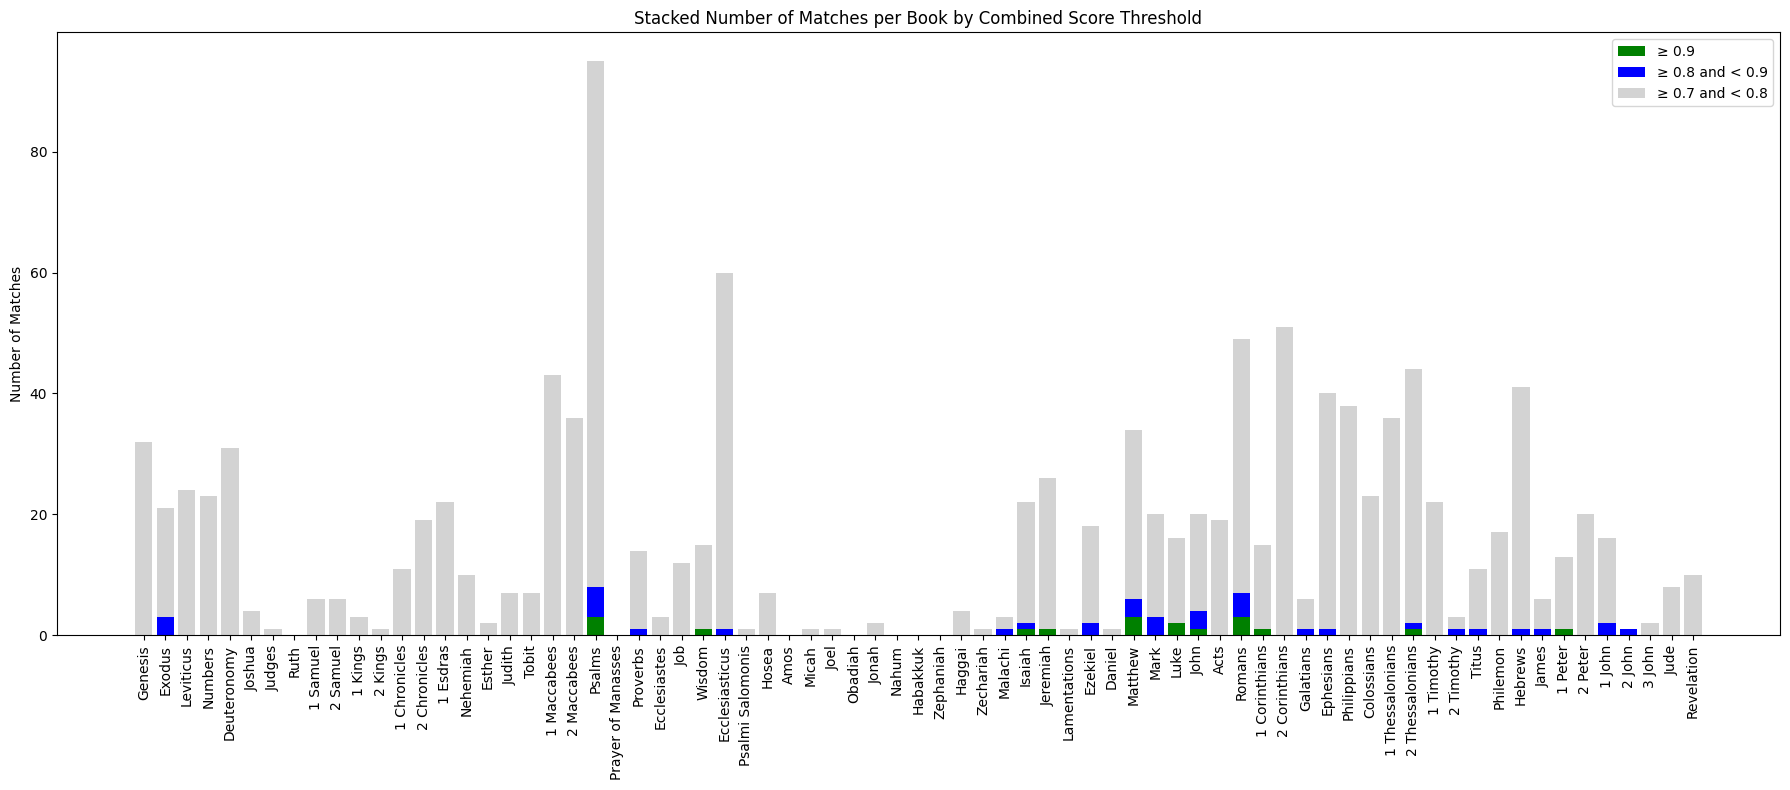

In [186]:
import pandas as pd
import matplotlib.pyplot as plt

# Count per threshold
thresholds = [0.7, 0.8, 0.9]
threshold_counts = {
    t: merged_df[merged_df["score"] >= t]["book"].value_counts()
    for t in thresholds
}

# Create DataFrame and reindex
plot_df = pd.DataFrame(threshold_counts).fillna(0).astype(int)
plot_df = plot_df.reindex(book_titles_sorted).fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(18, 8))
x = range(len(plot_df))

# Colors by threshold
colors = {
    thresholds[2]: "green",
    thresholds[1]: "blue",
    thresholds[0]: "lightgray"
}

# Stack the bars: 0.9 first, then 0.8–0.9, then 0.7–0.8
bottom_90 = plot_df[thresholds[2]]
height_80 = plot_df[thresholds[1]] - bottom_90
height_70 = plot_df[thresholds[0]] - plot_df[thresholds[1]]

# Plot each stacked layer
ax.bar(x, bottom_90, color=colors[thresholds[2]], label=f'≥ {thresholds[2]}')
ax.bar(x, height_80, bottom=bottom_90, color=colors[thresholds[1]], label=f'≥ {thresholds[1]} and < {thresholds[2]}')
ax.bar(x, height_70, bottom=plot_df[thresholds[1]], color=colors[thresholds[0]], label=f'≥ {thresholds[0]} and < {thresholds[1]}')

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(plot_df.index, rotation=90, fontsize=10)
ax.set_ylabel("Number of Matches")
ax.set_title("Stacked Number of Matches per Book by Combined Score Threshold")
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
Distributions of detected references to individual biblical books.Individual references are differentiated by color based on the cosine similarity score of the matched LaBSE embeddings. While values over 0.9 are mainly direct citation, values under 0.7 tend to be rather paraphrases.

In [187]:
fig.savefig("../figures/grela_register_ngram_comb_matches_v1.png", dpi=300)

In [202]:
# Create the co-occurrence table
cooc_df = merged_df.sort_values("combined_score")[:3000].pivot_table(
    index="subwork_id",
    columns="book",
    values="sentence",  # or any column that is non-null
    aggfunc="count",
    fill_value=0
)

# Reindex columns to follow your predefined order
cooc_df = cooc_df.reindex(columns=book_titles_sorted).fillna(0).astype(int)

In [203]:
cooc_df

book,Genesis,Exodus,Leviticus,Numbers,Deuteronomy,Joshua,Judges,Ruth,1 Samuel,2 Samuel,...,Philemon,Hebrews,James,1 Peter,2 Peter,1 John,2 John,3 John,Jude,Revelation
subwork_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
100,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0,0,2,0,0,0,0,0,0,...,0,2,0,0,0,1,0,0,0,0
96,1,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
97,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [204]:
cooc_df_filtered = cooc_df[cooc_df.sum(axis=1)>5]

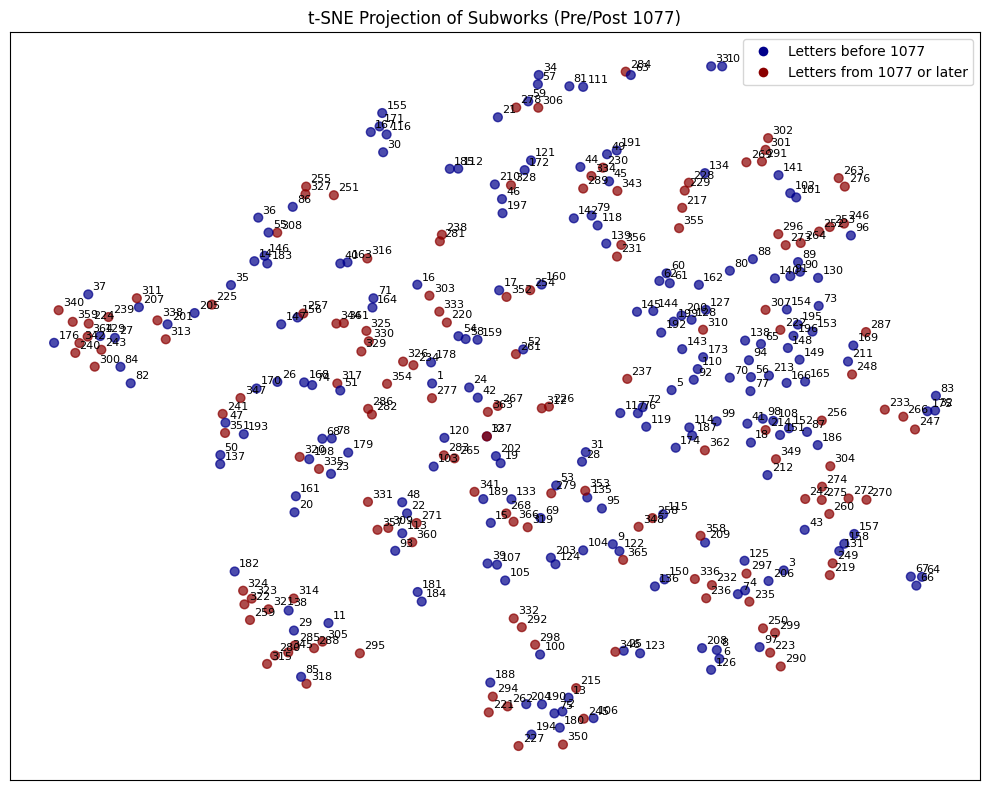

In [220]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=8, metric='cosine', random_state=42)
tsne_coords = tsne.fit_transform(cooc_df.values)

# Create DataFrame for plotting
tsne_df = pd.DataFrame({
    "x": tsne_coords[:, 0],
    "y": tsne_coords[:, 1],
    "subwork_id": cooc_df.index
})

# Determine colors based on subwork_id threshold
def get_color(subwork_id):
    try:
        return "darkred" if int(subwork_id) >= 214 else "darkblue"
    except:
        return "gray"

tsne_df["color"] = tsne_df["subwork_id"].apply(get_color)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    tsne_df["x"], tsne_df["y"],
    c=tsne_df["color"],
    s=40,
    alpha=0.7
)

# Optional: add text labels
for _, row in tsne_df.iterrows():
    ax.text(row["x"] + 0.5, row["y"] + 0.5, row["subwork_id"], fontsize=8)

# Formatting
ax.set_title("t-SNE Projection of Subworks (Pre/Post 1077)")
#ax.set_xlabel("t-SNE Dim 1")
#ax.set_ylabel("t-SNE Dim 2")
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Letters before 1077', markerfacecolor='darkblue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Letters from 1077 or later', markerfacecolor='darkred', markersize=8)
]
ax.legend(handles=legend_elements)

plt.tight_layout()
# Optionally save: fig.savefig("tsne_subwork_by_date.png")

Figure 1: 2-dimensional t-SNE projection of the distribution of references to Biblical books across individual letters. Dates differentiated by color.

In [219]:
fig.savefig("../figures/grela_register_ngram_comb_matches_v1_tsne.png", dpi=300)